In [40]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch_geometric
import Bio.PDB as PDB
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import proteinsolver
import pandas as pd

import modules

from modules.dataset_utils import *
from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

from pathlib import Path
# custom stuff
#import proteinsolver_utils
#import proteinsolver_datasets
np.random.seed(0)

import matplotlib.pyplot as plt

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "state_files" / "tcr_binding"

In [ ]:
# give path to ida data dir and metadata file (here, metadata row = idx of file)
# glob and load file sequentially
# split on _ to get index/target and partition
# send file path to partition
#
# when loading data during training, slice out each time variable from the data
# convert to tensor

In [62]:
# LOO validation
model_energies_dir = data_root / "test"

paths = list(model_energies_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.sort_values(by="#ID")
metadata = metadata.reset_index(drop=True)

LSTMEnergyDataset(
    paths=metadata["paths"]
    targets=metadata[binder]
)


#loo_train_partitions, loo_test_partitions, loo_valid_partitions, unique_peptides = generate_3_loo_partitions(metadata, valid_pep="KTWGQYWQV")


In [80]:
n_splits = 5
i = 1
test_idx = partitions[i]
partitions = [["A"], ["B"], ["C"], ["D"], ["E"]]
outer_train_folds = [partitions[j] for j in range(n_splits) if j != i]
inner_train_partitions, inner_valid_partitions = join_partitions(outer_train_folds)

In [81]:
print("test", test_idx)
print("train", outer_train_folds)
print("inner train", inner_train_partitions)
print("inner valid", inner_valid_partitions)

test ['B']
train [['A'], ['C'], ['D'], ['E']]
inner train [['C', 'D', 'E'], ['A', 'D', 'E'], ['A', 'C', 'E'], ['A', 'C', 'D']]
inner valid [['A'], ['C'], ['D'], ['E']]


In [ ]:
# 5 fold CV

metadata_path = data_root / "metadata.csv"

partitions = [list() for _ in range(5)]
targets = list()

paths = list(model_dir.glob("*"))
for path in paths:
    split = str(path).split("_")
    
    bind_str = split[-2]
    if bind_str == "pos":
        bind = 1
    else:
        bind = 0
    targets.append(bind)
    
    part = int(split[-3][0]) - 1
    partitions[part].append(path)

LSTMEnergyDataset(
    paths=paths
    targets=targets
)


In [ ]:
class LSTMEnergyDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        paths, 
        targets, 
        transform=None, 
        target_transform=None
    ):
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.annotations = torch.Tensor(targts)
        self.paths = paths

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        x = np.load(self.paths[idx])
        time_idx = [92, 116, 140]  # time variables to be removed
        for idx in time_idx:
            x[:,idx] = 0.0
        x = torch.from_numpy(x)
        y = self.annotations[idx]
        return x, y

In [66]:
t = "/home/sebastian/masters/data/neat_data/9978_2p_neg_swap.npy".split("_")
int(t[-3][0])

2

In [37]:
t = np.load("/home/sebastian/masters/data/neat_data/9978_2p_neg_swap.npy")
torch.from_numpy(t).shape

torch.Size([406, 142])

In [11]:
torch.load(processed_dir / "proteinsolver_embeddings_pos/data_1.pt").shape

torch.Size([414, 132])

In [5]:
dataset = LSTMDataset(
    data_dir=processed_dir / "proteinsolver_embeddings", 
    annotations_path=processed_dir / "proteinsolver_embeddings" / "targets.pt"
)

In [6]:
lens = list()
for i in range(len(dataset)):
    lens.append(len(dataset[i][0]))

(array([  1.,   0.,   5.,   4.,  17.,  24.,  76.,  86., 100., 100., 236.,
        262., 360., 577., 606., 931., 957., 920., 956., 902., 740., 734.,
        554., 457., 311., 197., 120.,  66.,  22.,  10.]),
 array([390., 391., 392., 393., 394., 395., 396., 397., 398., 399., 400.,
        401., 402., 403., 404., 405., 406., 407., 408., 409., 410., 411.,
        412., 413., 414., 415., 416., 417., 418., 419., 420.]),
 <a list of 30 Patch objects>)

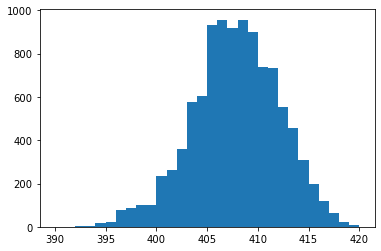

In [7]:
lens = np.array(lens)
plt.hist(lens, bins=len(np.unique(lens)))

In [144]:
len_x = np.where(lens == 392)
flattened = list()
targets = list()
for i in len_x[0]:
    x, y = dataset[i]
    x = x.flatten()
    flattened.append(x.numpy())
    targets.append(y.item())


IndexError: index 801 is out of bounds for axis 0 with size 10

In [91]:
class LSTMDatasetInMemory(torch.utils.data.Dataset):
    def __init__(
        self, 
        data_dir, 
        annotations_path, 
        transform=None, 
        target_transform=None
    ):
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.annotations = torch.Tensor(torch.load(annotations_path))
        self.data = np.array(
            [torch.load(f"{self.data_dir}/data_{idx}.pt") for idx in range(len(self.annotations))],
            dtype=object
        )
    
    def add_data(self, new_x, new_y):
        pass
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.annotations[idx]
        return x, y
    

In [94]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

dataset_1 = LSTMDataset(
    data_dir=processed_dir / "test_data", 
    annotations_path=processed_dir / "test_data" / "targets.pt"
)

dataset_2 = LSTMDatasetInMemory(
    data_dir=processed_dir / "test_data", 
    annotations_path=processed_dir / "test_data" / "targets.pt"
)

dataset = dataset_2

lengths = np.array([len(dataset[i][0]) for i in range(len(dataset))])

n_thresh = 0 #50  # TODO: set some number
for length in np.unique(lengths):
    length_idx = np.where(lengths == length)[0]
    if len(length_idx) > n_thresh:  # replace with try/except. Catches both no positive and too few data error.
        x_sub, y_sub = dataset[length_idx]
        x_sub = torch.stack([x for x in x_sub])
        
        # split embedding and pos encoding
        emb = x_sub[:,:,:-4]
        pos = x_sub[:,:,-4:]
        
        emb = emb.flatten(1)  # reshape to (n_sample, (emb_dim x len))
        
        sm = BorderlineSMOTE(sampling_strategy="minority", random_state=0)
        x_os, y_os = sm.fit_resample(emb, y_sub.squeeze(1))
        x_os = x_os[len(emb):]  # slice to only get syntheic data
        y_os = y_os[len(emb):]

        new_pos = #make a way to get representative positional encoding from x_sub
        x_os = x_os.unflatten(0, torch.Size([length, 128]))  # reshape back to (n_sample, emb_dim, len)
        x_os = torch.cat((x_os, new_pos), dim=2)  # add positional encoding

# load dataset
# get training partition
# stratify training partition on length
# for each length:
    #try:
        #join into one tensor
        #split off positional encoding
        #get positional encoding sequence that is representative of positives
        #flatten tensor
        #oversample with borderlinesmote
        #unflatten tensor
        #re-attach positional encodings to true positives
        #attach generated positional encoding to synthetic positives
    #except low count length or no positive:
        #skip oversampling
# take oversamplings for each length and join into new dataset
# give training data to training func as an iterabledataset instead of map-style

# we have to do it in memory since we have to oversample on training partition data only.
# maybe its better to do interpolation per peptide?? according to paolos message perhaps


#sm = BorderlineSMOTE(sampling_strategy="minority", random_state=0)
#x_os, y_os = sm.fit_resample(flattened, targets)

/tmp/ipykernel_779/4282447565.py:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  self.data = np.array(


In [139]:
x_sub, y_sub = dataset[length_idx]
y_sub = torch.stack((y_sub, y_sub, y_sub))
y_sub[1] = 1

In [151]:
pos = emb[:,:,-4:]

In [189]:
pos

tensor([[[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]]])

In [172]:
torch.stack((emb, pos), dim=3).shape

torch.Size([3, 414, 4, 2])

In [177]:
emb.shape

torch.Size([3, 414, 4])

In [178]:
pos.shape

torch.Size([3, 414, 4])

In [198]:
emb

tensor([[[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]]])

tensor([[[ 0.2346,  4.3500,  0.7100,  ...,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  ...,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419,  ...,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853,  ...,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  ...,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364,  ...,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100,  ...,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  ...,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419,  ...,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853,  ...,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  ...,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364,  ...,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100,  ...,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  ...,  1

In [142]:
sm = BorderlineSMOTE(sampling_strategy="minority", random_state=0)
x_os, y_os = sm.fit_resample(emb.flatten(1), y_sub.squeeze(1))

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 11

In [130]:
y_sub.numpy()

array([[0.],
       [0.],
       [0.]], dtype=float32)

In [95]:
x_sub.shape

(1,)

In [97]:
x_sub = torch.stack((x_sub[0], x_sub[0] ,x_sub[0]))

In [120]:
emb = x_sub[:,:,:-4]

In [125]:
emb.flatten(1).shape

torch.Size([3, 52992])

In [444]:
torch.Tensor(x_os[-2]).unflatten(0, torch.Size([396, 128]))

tensor([[-3.4573, -0.2002,  1.6379,  ...,  0.3475,  0.7875,  1.2294],
        [-5.4712,  0.9058,  0.8596,  ...,  3.1876, -1.0497,  1.7057],
        [-3.2194, -0.0836, -0.0969,  ...,  0.1556, -0.1512, -0.1089],
        ...,
        [-5.6118,  0.1372, -0.2350,  ..., -4.4966,  1.4147, -1.5574],
        [-5.9163,  0.8383,  1.1998,  ...,  3.0196, -0.5474,  1.6051],
        [ 0.1068, -0.1263, -0.4633,  ...,  1.2110,  1.3926, -2.2330]])

In [ ]:
#from_dir = "/home/sebastian/masters/data/210916_TCRpMHCmodels/models/"
#to_dir = "/home/sebastian/masters/data/neat_data/tcrpmhc/"
#model_suffix = "model_TCR-pMHC.pdb"
#for subdir in os.listdir(from_dir):
#    subdir_id = subdir.split("_")[0]
#    new_name = f"tcrpmhc_{subdir_id}.pdb"
#    os.system(f"mv {from_dir}/{subdir}/{model_suffix} {to_dir}/{new_name}")
#    
#from_dir = "/home/sebastian/masters/data/embedding_verification/raw_filtered_models"
#to_dir = "/home/sebastian/masters/data/neat_data/pmhc/"
#model_suffix = "model_pMHC.pdb"
#for subdir in os.listdir(from_dir):
#    subdir_id = subdir.split("_")[0]
#    new_name = f"pmhc_{subdir_id}.pdb"
#    os.system(f"mv {from_dir}/{subdir}/{model_suffix} {to_dir}/{new_name}")
#    
#from_dir = "/home/sebastian/masters/data/embedding_verification/raw_filtered_models"
#to_dir = "/home/sebastian/masters/data/neat_data/p/"
#model_suffix = "model_p.pdb"
#for subdir in os.listdir(from_dir):
#    subdir_id = subdir.split("_")[0]
#    new_name = f"p_{subdir_id}.pdb"
#    os.system(f"mv {from_dir}/{subdir}/{model_suffix} {to_dir}/{new_name}")

In [ ]:
UNIQUE_ID = "191f05de"
BEST_STATE_FILES = {
    #
    "191f05de": "/home/sebastian/proteinsolver/data/e53-s1952148-d93703104.state"
}
state_file = BEST_STATE_FILES[UNIQUE_ID]


#test_file = "/home/sebastian/proteinsolver/notebooks/protein_demo/inputs/1n5uA03.pdb"
#test_id = "1n5uA03.pdb"

test_file = "/home/sebastian/masters/data/test/3hfm.pdb"
test_id = "3hfm"

def load_model_paths(data_dir, model="model_TCR-pMHC.pdb"):
    model_list = list()
    for subdir in os.listdir(data_dir):
        path = f"{data_dir}/{subdir}/{model}"
        model_list.append(path)
    return np.array(model_list)

infiles = load_model_paths("/home/sebastian/masters/data/210916_TCRpMHCmodels/models/")

In [ ]:
structure_all = kmbio.PDB.load(infiles[0])
structure_all = merge_chains(structure_all)
structure = kmbio.PDB.Structure(test_id, structure_all[0].extract('A'))

pdata = proteinsolver.utils.extract_seq_and_adj(structure, 'A', remove_hetatms=True)
data = proteinsolver.datasets.row_to_data(pdata)
data = proteinsolver.datasets.transform_edge_attr(data)
data.to(device)

In [5]:
import torch.nn.functional as F

In [6]:
F.softmax()

TypeError: softmax() missing 1 required positional argument: 'input'

In [ ]:
#train_loader = iter(torch_geometric.data.DataLoader(d_train, batch_size=batch_size))
#valid_loader = iter(torch_geometric.data.DataLoader(d_valid, batch_size=batch_size))
#d = next(train_loader)
#x = torch.ones_like(d.x)*d.x.max().item()
#out = gnn(x, d.edge_index, d.edge_attr)
#
#net.eval()
#with torch.no_grad():
#    y = net(out.T.unsqueeze(0))
#    y = F.softmax(y, dim=0)


In [ ]:
def gnn_to_fnn(data, hidden_size, gnn_instance):
        data = data.to(device)
        y = data.y.to(device)
        with torch.no_grad():
            out = gnn_instance(data.x, data.edge_index, data.edge_attr)
        
        batches = torch.unique(data.batch)
        sliced_outs = list()
        pool = nn.AdaptiveAvgPool1d(output_size=hidden_size)
        for batch_idx in batches:
            batch_slice = torch.nonzero(data.batch == batch_idx)
            chain_map = data.chain_map[batch_idx]
            out_sliced = out[batch_slice]
            out_sliced = out_sliced[chain_map == "P"]  # get peptide only
            out_sliced = pool(out_sliced.T)
            sliced_outs.append(out_sliced)
        batched_out = torch.cat(sliced_outs, dim=1)
        return out, y
    
def gnn_to_lstm_batch(data, gnn_instance, device, num_classes):
    """function for bridging gnn output to lstm"""
    data = data.to(device)
    y = data.y
    with torch.no_grad():
        out = gnn_instance(data.x, data.edge_index, data.edge_attr)
    
    batches = torch.unique(data.batch)
    sliced_embeddings = list()
    encoded_y = list()
    for batch_idx in batches:
        # split sub graphs into batches
        batch_slice = torch.nonzero(data.batch == batch_idx)
        chain_map = data.chain_map[batch_idx]
        one_batch_peptide_emb = out[batch_slice][chain_map == "P"]  # get peptide only
        sliced_embeddings.append(one_batch_peptide_emb.squeeze(1))
        
        # one hot encode targets
        sliced_y = int(y[batch_idx].item())
        one_hot_y = np.zeros(num_classes)
        one_hot_y[sliced_y] = 1
        encoded_y.append(one_hot_y)
        
    sliced_embeddings.sort(key=lambda x: len(x))
    encoded_y = torch.Tensor(encoded_y)
    
    return sliced_embeddings, encoded_y

In [ ]:
class MyFNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(hidden_size * num_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)  # output dim should be 3 long
        )

    def forward(self, x):
        x = x.T.flatten()
        x = self.linear(x)
        return x

In [ ]:
# init proteinsolver gnn
num_features = 20
adj_input_size = 2
hidden_size = 128
#frac_present = 0.5
#frac_present_valid = frac_present
#info_size= 1024

gnn = Net(
    x_input_size=num_features + 1, 
    adj_input_size=adj_input_size, 
    hidden_size=hidden_size, 
    output_size=num_features
)
gnn.load_state_dict(torch.load(state_file, map_location=device))
gnn.eval()
gnn = gnn.to(device)

In [ ]:
#from sklearn.model_selection import KFold
#from sklearn.metrics import *
#from torch import nn, optim
#import torch.nn.functional as F
#
#
#root = Path("/home/sebastian/masters/data/")
#data_root = root / "neat_data"
#metadata_path = data_root / "embedding_dataset.csv"
#processed_dir = data_root / "processed" / "embedding_verification"
#state_file = root / "state_files" / "e53-s1952148-d93703104.state"
#out_dir = root / "state_files" / "embedding_verification" 
#
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#
## load dataset
#raw_files = list()
#targets = list()
#with open(metadata_path, "r") as infile:
#    for line in infile:
#        line = line.strip().split(",")
#        raw_files.append(line[0])
#        targets.append(int(line[1]))
#
#raw_files = np.array(raw_files)
#targets = np.array(targets)
#
#dataset = ProteinDataset(processed_dir, raw_files, targets, overwrite=False)
#
## init proteinsolver gnn
#num_features = 20
#adj_input_size = 2
#hidden_size = 128
#
#gnn = Net(
#    x_input_size=num_features + 1, 
#    adj_input_size=adj_input_size, 
#    hidden_size=hidden_size, 
#    output_size=num_features
#)
#gnn.load_state_dict(torch.load(state_file, map_location=device))
#gnn.eval()
#gnn = gnn.to(device)
#
## init LSTM
#num_classes = 3
#num_layers = 2
#hidden_size = 26
#
#net = MyLSTM(num_classes, num_features, num_layers, hidden_size)
#net = net.to(device)
#
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(net.parameters(), lr=0.0001) 
#
## training params
#epochs = 1
#n_splits = 5
#batch_size = 5
#
## touch files to ensure output
#save_dir = get_non_dupe_dir(out_dir)
#loss_paths = touch_output_files(save_dir, "loss", n_splits)
#state_paths = touch_output_files(save_dir, "state", n_splits)
#pred_paths = touch_output_files(save_dir, "pred", n_splits)
#
#CV = KFold(n_splits=n_splits, shuffle=True)
#i = 0
#for train_idx, valid_idx in CV.split(dataset):
#    
#    train_subset = dataset[torch.LongTensor(train_idx)][0:10]
#    valid_subset = dataset[torch.LongTensor(valid_idx)][0:10]
#    
#    net = MyLSTM(num_classes, num_features, num_layers, hidden_size)
#    net = net.to(device)
#    
#    # partial function - gnn arg is static, x is given later
#    gnn_transform = lambda x: gnn_to_lstm_batch(
#        x, 
#        gnn_instance=gnn, 
#        device=device,
#        num_classes=num_classes
#)
#    
#    net, train_subset_losses, valid_subset_losses = train_model(
#        model=net,
#        epochs=epochs, 
#        criterion=criterion,
#        optimizer=optimizer,
#        train_data=train_subset, 
#        valid_data=valid_subset,
#        batch_size=batch_size,
#        device=device,
#        transform=gnn_transform,
#)
#
#    torch.save({"train": train_subset_losses, "valid": valid_subset_losses}, loss_paths[i])
#    torch.save(net.state_dict(), state_paths[i])
#    
#    # perform test preds
#    y_pred, y_true = predict(
#        model=net, 
#        data=train_subset, 
#        batch_size=batch_size,
#        device=device,
#        transform=gnn_transform,
#)
#
#    torch.save({"y_pred": y_pred, "y_true": y_true,}, pred_paths[i])
#    
#    i += 1


In [ ]:
    #annotations = train_subset.dataset.annotations.squeeze(1)
    #class_weights = compute_class_weight(
    #    'balanced',
    #    np.unique(annotations),
    #    annotations.numpy()
    #)
    #class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
#def pad_collate_chain_split(batch, pad_val=0):
#    (xx, yy) = zip(*batch)
#    x_1_batch = list()
#    x_2_batch = list()
#    x_3_batch = list()
#    x_4_batch = list()
#    for x in xx:
#        x_1_batch.append(x[x[:,-1] == 1][:,:-4])  # slice based on positional encoding and remove encoding part
#        x_2_batch.append(x[x[:,-2] == 1][:,:-4])
#        x_3_batch.append(x[x[:,-3] == 1][:,:-4])
#        x_4_batch.append(x[x[:,-4] == 1][:,:-4])
#
#    x1_pad = nn.utils.rnn.pad_sequence(x_1_batch, batch_first=True, padding_value=pad_val)
#    x2_pad = nn.utils.rnn.pad_sequence(x_2_batch, batch_first=True, padding_value=pad_val)
#    x3_pad = nn.utils.rnn.pad_sequence(x_3_batch, batch_first=True, padding_value=pad_val)
#    x4_pad = nn.utils.rnn.pad_sequence(x_4_batch, batch_first=True, padding_value=pad_val)
#    yy_pad = nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=pad_val)
#    return (x1_pad, x2_pad, x3_pad, x4_pad), yy_pad



In [ ]:
def lstm_train(
    model,
    epochs,
    criterion,
    optimizer,
    dataset,
    train_idx, 
    valid_idx,
    batch_size,
    device,
):
    train_losses = list()
    valid_losses = list()
    
    for e in range(epochs):
        train_loader = DataLoader(dataset=dataset, batch_size=batch_size, collate_fn=pad_collate)
        valid_loader = DataLoader(dataset=dataset, batch_size=batch_size, collate_fn=pad_collate)

        train_len = len(train_loader)
        valid_len = len(valid_loader)

        train_loss = 0
        model.train()
        j = 0
        for x, y, _, _ in train_loader:    
            y = y.to(device)
            x = x.to(device)
            y_pred = model(x)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            display_func(j, train_len, e, train_losses, valid_losses)
            j += 1
            
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for x, y, _, _ in valid_loader:    
                y = y.to(device)
                x = x.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                valid_loss += loss.item()

        train_losses.append(train_loss / train_len)
        valid_losses.append(valid_loss / valid_len)

    return model, train_losses, valid_losses


def lstm_predict(model, dataset, idx, device):
    data_loader = DataLoader(dataset=dataset, sampler=idx, batch_size=1, shuffle=False, collate_fn=pad_collate)
    pred = list()
    true = list()
    with torch.no_grad():
        for x, y, _, _ in data_loader:    
            y = y.to(device)
            x = x.to(device)
            y_pred = model(x)
            pred.append(torch.sigmoid(y_pred))
            true.append(y)
    return torch.Tensor(pred), torch.Tensor(true)
